In [1]:
import jieba
import time
import jieba.posseg as pseg
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from snownlp import SnowNLP
from multiprocessing import Pool
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 引言

项目前置的数据获取工作已完成，现在我们需要在此完成基金评论的数据的情感分析。
整体分析过程将划分为以下部分：
- 使用SnowNLP生成情感值
- 利用情感值进行属性构造，通过matplotlib绘图

# 开始

1 使用SnowNLP生成情感值

1.1 此处选取基金——易方达中小盘混合 (110011) 作为案例，*calc_sentiment()* 将通过Pandas的 *apply()* 方法读取每一行的评论内容生成对应的情感值

In [2]:
# process sentiment
def calc_sentiment(row):
    sentiments = SnowNLP(row['comment']).sentiments
    return sentiments

def proc_sentiment(tradingcode='110011'):
    comment_dataframe = pd.read_pickle("comment_dataframe")
    fund_comment = comment_dataframe[comment_dataframe['tradingcode']==tradingcode]
    fund_comment['sentiment'] = fund_comment.apply(calc_sentiment, axis=1)
    return fund_comment

1.2 时间单位转换

In [3]:
fund_comment = proc_sentiment()
fund_comment = fund_comment.reset_index()
fund_comment = fund_comment.rename(columns={'level_0':'user', 'level_1':'time'})
fund_comment = fund_comment.set_index('time')
fund_comment.index = [pd.to_datetime(time.strftime('%Y-%m-%d')) for time in fund_comment.index] # index转为年月日格式重新赋值
fund_comment.index.name = 'time'

/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


2 利用情感值进行属性构造，通过matplotlib绘图

2.1 选取过去120天的情感值，根据index(time)进行按天groupby后，计算每一组的情感均值sentiment_mean，绘图观察

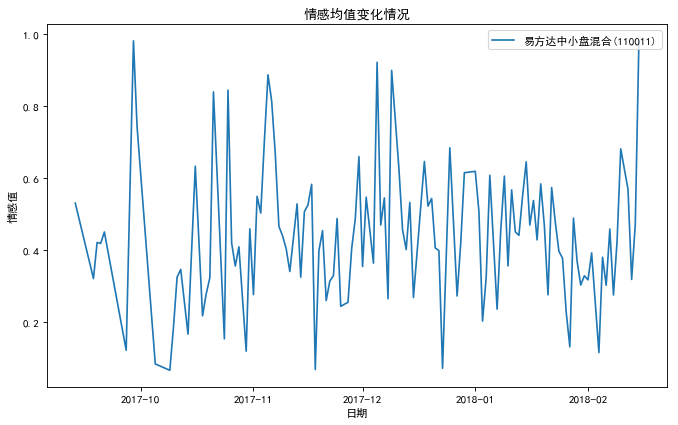

In [4]:
sentiment_mean = fund_comment['sentiment'].groupby('time').mean().iloc[-120:]
plt.figure(figsize=(10,6),dpi=80)
plt.plot(sentiment_mean, label='易方达中小盘混合(110011)')
plt.legend(loc='upper right')
plt.xlabel('日期')
plt.ylabel('情感值')
plt.title('情感均值变化情况')
plt.show()

2.2 计算上述情感均值sentiment_mean较昨日的变化情况，计算sentiment_diff，绘图观察

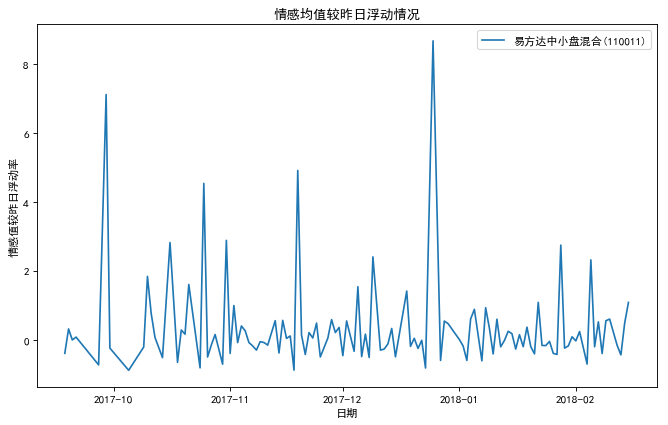

In [5]:
sentiment = sentiment_mean
sentiment_shift = sentiment / sentiment.shift(1) - 1
plt.figure(figsize=(10,6),dpi=80)
plt.plot(sentiment_shift, label='易方达中小盘混合(110011)')
plt.legend(loc='upper right')
plt.xlabel('日期')
plt.ylabel('情感值较昨日浮动率')
plt.title('情感均值较昨日浮动情况')
plt.show()

2.3 通过绘图观察发现，较昨日的变化情况波动较大，因此尝试通过情感值均值的7天移动均值变化情况，计算sentiment_mov_7，绘图观察

In [6]:
ma = 7
sentiment_mean['mov_7'] = np.round(sentiment_mean.rolling(center=False, window=ma).mean(), 6)

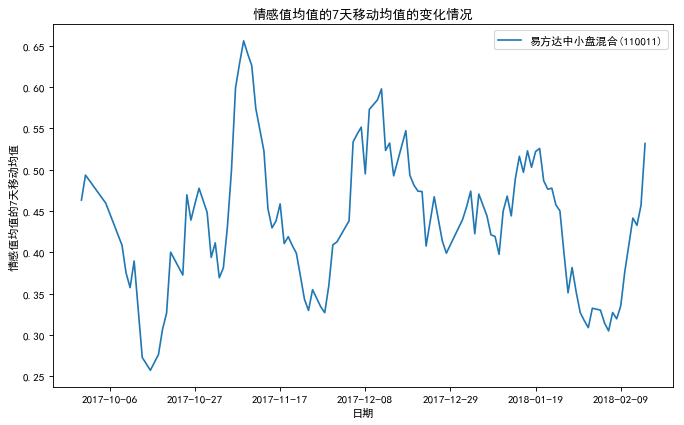

In [7]:
sentiment_mov_7 = sentiment_mean['mov_7']
sentiment_mov_7 = sentiment_mov_7.dropna()
plt.figure(figsize=(10,6),dpi=80)
plt.plot(sentiment_mov_7, label='易方达中小盘混合(110011)')
plt.legend(loc='upper right')
plt.xlabel('日期')
plt.ylabel('情感值均值的7天移动均值')
plt.title('情感值均值的7天移动均值的变化情况')
plt.show()

2.4 时间轴拉长至140天，查看情感值均值的14天移动均值变化情况，计算sentiment_mov_14，绘图观察

In [8]:
sentiment_mean = fund_comment['sentiment'].groupby('time').mean().iloc[-140:]
ma = 14
sentiment_mean['mov_14'] = np.round(sentiment_mean.rolling(center=False, window=ma).mean(), 6)

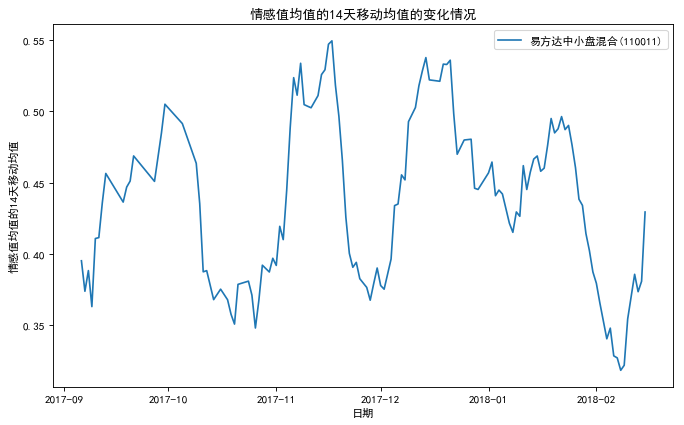

In [9]:
sentiment_mov_14 = sentiment_mean['mov_14']
sentiment_mov_14 = sentiment_mov_14.dropna()
plt.figure(figsize=(10,6),dpi=80)
plt.plot(sentiment_mov_14, label='易方达中小盘混合(110011)')
plt.legend(loc='upper right')
plt.xlabel('日期')
plt.ylabel('情感值均值的14天移动均值')
plt.title('情感值均值的14天移动均值的变化情况')
plt.show()